# Problem

We need to repeatedly choose between performing one of M actions to maximize the total reward for N rounds. Each action returns a random reward drawn from an unknown distribution that depends on the context of the action. In this notebook, the distributions of rewards are normal with randomly assigned means between -1 and 1 and randomly assigned variances between 0 and 1.

In [2]:
# Import libraries
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

# Parameter setup

In [3]:
actions = 3 # number of possible actions
customers = 10000 # number of choices made in 1 simulation
confidence = 0.95 # confidence level

path = "/home/aleksey/Desktop/FellowshipAI/data_snippet.csv"

alpha = 1. + np.sqrt(0.5*np.log(2./(1. - confidence)))

# For testing purposes only
distributions = 2 # number of different reward distributions

# Toy dataset setup

We will assume that our customers are characterized by 2 parameters: age and ARPU, and thus the context for each customer is 2-dimensional. Each customer falls into one of two groups that receive different rewards for taking the same actions.
* The ages of customers in the first group are drawn from a normal distribution with mean 25 and standard deviation 5;
* The ARPUs for customers in the first group are drawn from a normal distribution with mean 100 and standard deviation 15;
* The ages of customers in the second group are drawn from a normal distribution with mean 45 and standard deviation 6;
* The ARPUs for customers in the second group are drawn from a normal distribution with mean 50 and standard deviation 25;
* The minimum age for customers in both groups is set to 18, and the ARPUs must be positive.

In [4]:
# Copied from space-bandits
def get_customer(ctype=None):
    """Customers come from two feature distributions.
    Class 1: mean age 25, stdev 5 years, min age 18
             mean ARPU 100, stdev 15
    Class 2: mean age 45, stdev 6 years
             mean ARPU 50, stdev 25
    """
    if ctype is None:
        if random.random() > .5: #coin toss
            ctype = 1
        else:
            ctype = 2
    age = 0
    ft = -1
    if ctype == 1:
        while age < 18:
            age = np.random.normal(25, 5)
        while ft < 0:
            ft = np.random.normal(100, 15)

    if ctype == 2:
        while age < 18:
            age = np.random.normal(45, 6)
        while ft < 0:
            ft = np.random.normal(50, 25)

    age = round(age)
    return ctype, (age, ft)

The following figure shows the distributions of rewards for all possible actions for the customers in the first group (upper panel) and in the second group (lower panel). The x and y scales are the same for both figures. Notice that actions may have either positive or negative means.

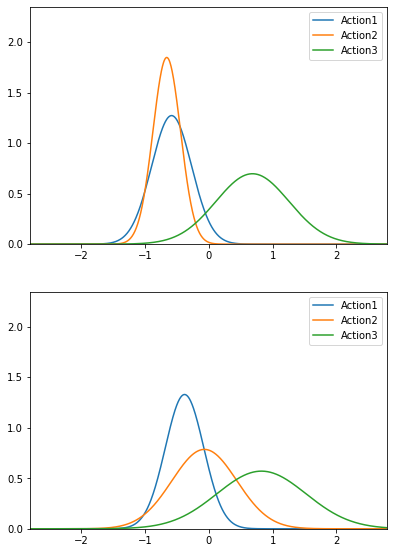

In [5]:
# Generate training and validation datasets:
# -- context: 2 features, age and ARPU
# -- reward: real number
# -- two types of customers differ in age and ARPU

# Set up distributions of rewards:
# normal, with randomly selected mean and variance for each action and customer type

# mean rewards for each of the possible actions and each of the 2 customer types
mean = [[2*(random.random()-0.5) for i in range(actions)] for j in range(distributions)]
# standard deviations of rewards for each of the possible actions and each of the 2 customer types
stdev = [[random.random() for i in range(actions)] for j in range(distributions)]

# find ranges for x and y values
min_sigma = 1.E5
max_sigma = 0.
for i in range(distributions):
    if max(stdev[i]) > max_sigma:
        max_sigma = max(stdev[i])
    if min(stdev[i]) < min_sigma:
        min_sigma = min(stdev[i])
xlimit = 4*max_sigma
ylimit = stats.norm.pdf(0,0,min_sigma)+0.5

# plot distributions of rewards: separate panel for each of the 2 customer types
fig, axs = plt.subplots(distributions, figsize=(6.4, 4.8*distributions))
plt.setp(axs, xlim=(-xlimit,xlimit), ylim=(0,ylimit))
for distribution in range(distributions):
    for action in range(actions):
        mu = mean[distribution][action]
        sigma = stdev[distribution][action]
        x = np.linspace(-xlimit, +xlimit, 1000)
        axs[distribution].plot(x, stats.norm.pdf(x, mu, sigma), label="Action"+str(action+1))
    axs[distribution].legend()

Now, we generate a dataset for the LinUCB algorithm. The dataset consists of two lists:
* contexts: a list of column vectors, represented by numpy arrays with dimensions (context size, 1); each context corresponds to one customer; for the toy dataset, the context size is 2.
* rewards: a list of numpy arrays with dimensions (number of possible actions,); each element in the numpy array is the reward for one of the possible actions.

In [6]:
# Generate customer dataset

contexts = [] # contexts provided for each customer
              # a context is a numpy array with dimensions (context_dim, 1) (column vectors)
rewards = []  # rewards that would have been received by each customer for each possible action
              # possible rewards are numpy arrays with dimensions (actions,)

cust = get_customer() 
context_dim = len(cust[1]) # dimensions of the context

for customer in range(customers):
    cust = get_customer() 
    customer_type = cust[0] - 1 # customer type
    contexts.append( np.asarray(cust[1]).reshape((context_dim, 1)) ) # add context for customer to dataset

    # possible rewards for each customer are randomly sampled from the distributions
    # for each of the possible actions for the given customer type
    possible_rewards = np.zeros(actions)
    for action in range(actions):
        mu = mean[customer_type][action]
        sigma = stdev[customer_type][action]
        possible_rewards[action] = np.random.normal(mu, sigma)
        
    rewards.append(possible_rewards) # add rewards received to dataset

Running the following cell summarizes the features of the toy dataset:

In [7]:
# Print out details of the toy dataset

print ("There are {:d} customers in the dataset.".format(customers))
if len(contexts) == len(rewards):
    print ("Possible rewards are provided for each customer.")
print ("The dimensions of the context for each customer in the dataset are:", contexts[0].shape)
print ("The dimensions of the possible rewards for each customer in the dataset are:", rewards[0].shape)
if rewards[0].shape[0] == actions:
    print ("The number of possible rewards for each customer is the same as the number of possible actions.")

There are 10000 customers in the dataset.
Possible rewards are provided for each customer.
The dimensions of the context for each customer in the dataset are: (2, 1)
The dimensions of the possible rewards for each customer in the dataset are: (3,)
The number of possible rewards for each customer is the same as the number of possible actions.


# LinUCB class

This is an implementation of Algorithm 1 in the following paper: Lihong Li, Wei Chu, John Langford, Robert E. Schapire. A Contextual-Bandit Approach to Personalized News Article Recommendation (arXiv:1003.0146).

The following cell defines the LinUCB class. When an instance of this class is created, the user must supply 4 arguments:
* The number of possible actions;
* The list of contexts for all customers;
* The list of rewards for all customers;
* A boolean value specifying the simulation mode: True - offline, False - online (currently, only offline simulations are available).

If the model has been pretrained, starting values for LinUCB parameters A and b may be included as optional arguments:
* A - list of length equal to the number of possible actions; each list element is a square numpy arrays of size (context size, context size);
* b - list of length equal to the number of possible actions; each list element is a column vector, that is, a numpy array with dimensions (context size, 1).

The method offLinUCB() can be used to run the LinUCB algorithm in offline mode. This method takes no arguments. Please see comments in the code for more details.

In [8]:
# LinUCB class required parameters:
# -- actions - number of possible actions: integer
# -- contexts - contexts for each step: list of column vectors, np arrays with dimensions (num features, 1)
# -- rewards - possible rewards for each step: list of np arrays with dimensions (actions,) (offline)
# -- offline - regime: boolean, True - offline, False - online (currently offline only)

# LinUCB weights (optional), will be initialized automatically, unless specified:
# -- A - list of length actions, list elements are square np arrays of size (num features, num features)
# -- b - list of length actions, list elements are column vectors, np arrays with dimensions (num features, 1)

class LinUCB:
    
    def __init__(self, actions, contexts, rewards, offline, A=None, b=None):

        # Inputs (see above)
        
        if isinstance(actions, int) == True:
            self.actions = actions
        else:
            raise ValueError("The number of possible actions must be an integer!\n")
            
        try:
            if len(contexts) == len(rewards) and rewards[0].shape == (self.actions,):
                self.contexts = contexts
                self.rewards = rewards
            elif len(contexts) != len(rewards):
                raise ValueError("The number of contexts and rewards must be the same!\n")
            else:
                raise ValueError("Rewards for all possible actions must be specified!\n")
        except:
            raise ValueError("Wrong format for contexts or rewards!\n")
        
        if isinstance(offline, bool) == True:
            self.offline = offline
        else:
            raise ValueError("offline must have a bool value!\n")
        
        # Parameters (see above)
        
        self.context_dim = self.contexts[0].shape[0] # number of features in context
        
        if (A == None) or (b == None): # initialize LinUCB parameters A and b if not provided
            self.A = [np.identity(self.context_dim) for action in range(self.actions)]
            self.b = [np.zeros((self.context_dim,1)) for action in range(self.actions)]
        else: # check that provided A and b parameters are in the right format
            try:
                if len(A) == len(b) == self.actions and A[0].shape == (self.context_dim, self.context_dim) and b[0].shape == (self.context_dim,1):
                    self.A = A
                    self.b = b
                else:
                    raise ValueError("Wrong format for A or b parameters!\n")
            except:
                raise ValueError("Wrong format for A or b parameters!\n")

        
        # Outputs
        
        self.total_rewards = [0.] # Total rewards for each step

        # The following metrics are only meaningful in offline mode (lists with a single 0. in online mode)
        self.max_total_rewards = [0.] # Total rewards for each step when always choosing action with highest mean reward
        self.random_total_rewards = [0.] # Total rewards for each step when randomly selecting an action
        

    # Select an action for the provided context using LinUCB algorithm
    # -- context is a single column vector, np array with dimensions (num features, 1)
    def get_action(self, context):

        p = [0 for action in range(self.actions)]
        for action in range(self.actions):
            A_inv = np.linalg.inv(self.A[action])
            theta = np.dot( A_inv, self.b[action] )
            p[action] = np.dot(theta.T, context) + alpha*np.sqrt( np.dot( np.dot(context.T, A_inv), context) )
        action = p.index(max(p).squeeze())
    
        return action


    # Get reward for the selected action
    # -- action is a single integer between 0 and (actions-1)
    # -- possible rewards is an np arrays with dimensions (actions,) in offline mode
    #    and ? in online mode
    def get_reward(self, action, possible_rewards):
    
        if self.offline == True:
            reward = possible_rewards[action]
    
        return reward    

    
    # Update parameters according to the LinUCB algorithm
    # -- context is a single column vector, np array with dimensions (num features, 1)
    # -- action is a single integer between 0 and (actions-1)
    # -- reward is a single floating point number
    def update_params(self, context, action, reward):
    
        self.A[action] = self.A[action] + context @ context.T
        self.b[action] = self.b[action] + context * reward
    

    # Take a single step in the LinUCB algorithm: select action, get reward, update parameters
    def take_step(self, context, possible_rewards):

        action = self.get_action(context) # select action
        reward = self.get_reward(action, possible_rewards) # get associated reward
                                                  # if offline = True: provide rewards for all possible actions
                                                  # if offline = False: play selected action, get reward
        self.update_params(context, action, reward) # update parameters
    
        return reward


    # Run LinUCB algorithm in offline mode
    def offLinUCB(self):

        customers = len(self.contexts) # get number of customers in training data

        for customer in range(customers): # for each customer in the training data
            context = self.contexts[customer] # get the context
            possible_rewards = self.rewards[customer] # get the possible rewards
            reward = self.take_step(context, possible_rewards) # run one step of LinUCB
            self.total_rewards.append(self.total_rewards[-1] + reward)
            self.max_total_rewards.append(self.max_total_rewards[-1] + max(possible_rewards))
            random_action = random.randint(0,self.actions-1)
            self.random_total_rewards.append(self.random_total_rewards[-1] + possible_rewards[random_action])

# Testing the model in offline mode

First, let's create an instance of the LinUCB class and train the model from scratch using the offLinUCB() method. We can see that the model ("policy" line on the graph) performs considerably better than randomly picking actions ("random" line on the graph). However, the reward that we get with the help of the LinUCB algorithm is smaller than the reward that we would get (on average) if we could pick the best possible action for each customer ("max" line on the graph).

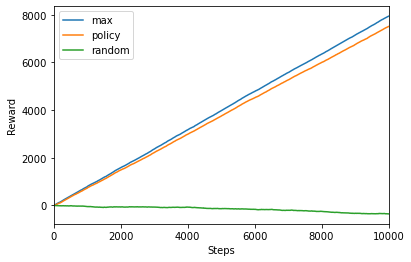

In [9]:
# create instance of LinUCB class with freshly initialized A and b parameters
lin = LinUCB(actions, contexts, rewards, True)
# run simulation in offline mode
lin.offLinUCB()

# plot the results
plt.plot(lin.max_total_rewards, label = 'max')
plt.plot(lin.total_rewards, label = 'policy')
plt.plot(lin.random_total_rewards, label = 'random')
plt.legend()
plt.xlim(0,10000)
plt.xlabel('Steps')
_ = plt.ylabel('Reward')

Now, let's create an instance of the LinUCB class and provide the model the weights A and b that we pre-trained in the previous step as a starting point. Then, let's run the model on the same data. Will it perform better?

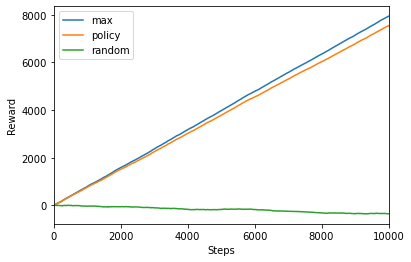

In [10]:
# Set A and b parameters to previously output values
# providing values of wrong types and/or sizes throws an error
A = lin.A
b = lin.b

# create instance of LinUCB class with these A and b parameters
lin2 = LinUCB(actions, contexts, rewards, True, A, b)
# run simulation in offline mode
lin2.offLinUCB()

# plot the results
plt.plot(lin2.max_total_rewards, label = 'max')
plt.plot(lin2.total_rewards, label = 'policy')
plt.plot(lin2.random_total_rewards, label = 'random')
plt.legend()
plt.xlim(0,10000)
plt.xlabel('Steps')
_ = plt.ylabel('Reward')

It's hard to tell from the graph above. Let's zoom in on the first 1000 (top panel) and the last 1000 (bottom panel) points in the data for the pre-trained and the newly trained models. We see that early on, the pretrained model performs better than the newly trained model. However, sooner or later the lines become more or less parallel to each other, meaning that the newly trained model has learned the same policy as the pre-trained model. From then on, the two models perform equally well. How soon it happens, depends on the distributions of rewards.

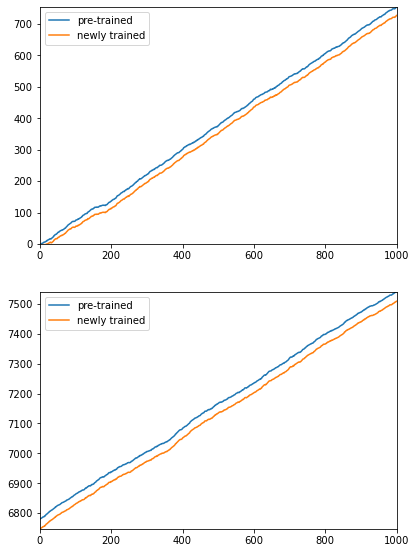

In [11]:
fig, axs = plt.subplots(2, figsize=(6.4, 9.6))
y_min = min(min(lin.total_rewards[:1000]), min(lin2.total_rewards[:1000]))
y_max = max(max(lin.total_rewards[:1000]), max(lin2.total_rewards[:1000]))
plt.setp(axs[0], xlim=(0,1000), ylim=(0,y_max))
y_min = min(min(lin.total_rewards[-1000:]), min(lin2.total_rewards[-1000:]))
y_max = max(max(lin.total_rewards[-1000:]), max(lin2.total_rewards[-1000:]))
plt.setp(axs[1], xlim=(0,1000), ylim=(y_min,y_max))

axs[0].plot(lin2.total_rewards[:1000], label = 'pre-trained')
axs[0].plot(lin.total_rewards[:1000], label = 'newly trained')
axs[0].legend()
axs[1].plot(lin2.total_rewards[-1000:], label = 'pre-trained')
axs[1].plot(lin.total_rewards[-1000:], label = 'newly trained')
_ = axs[1].legend()

# Testing the model on data snippet

Load the data snippet

In [12]:
data = pd.read_csv(path) # Load data snippet
data.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


Set up the contexts and rewards for customers in the dataset.

context = (retention score, recency score, frequency score)

rewards:

* 1 for sending an email and 0 for not sending if the email is opened;
* -1 for sending an email and 0 for not sending if the email is not opened.

In [13]:
# Set up dataset from data snippet

actions = 2
n_features = 3
contexts = []
rewards = []

for index, row in data.iterrows():
    context = np.zeros((n_features,1))
    context[0][0] = row['retention_score']
    context[1][0] = row['recency_score']
    context[2][0] = row['frequency_score']
#    if index == 0: print (type(context[0][0]), type(context[1][0]), type(context[2][0]))
    contexts.append(context)
    if row['opened'] == 1:
        rewards.append(np.asarray([1., 0.]))
    else:
        rewards.append(np.asarray([-1., 0.]))

In [14]:
# Print out details of the dataset

print ("There are {:d} customers in the dataset.".format(customers))
if len(contexts) == len(rewards):
    print ("Possible rewards are provided for each customer.")
print ("The dimensions of the context for each customer in the dataset are:", contexts[0].shape)
print ("The dimensions of the possible rewards for each customer in the dataset are:", rewards[0].shape)
if rewards[0].shape[0] == actions:
    print ("The number of possible rewards for each customer is the same as the number of possible actions.")

There are 10000 customers in the dataset.
Possible rewards are provided for each customer.
The dimensions of the context for each customer in the dataset are: (3, 1)
The dimensions of the possible rewards for each customer in the dataset are: (2,)
The number of possible rewards for each customer is the same as the number of possible actions.


In [15]:
# create instance of LinUCB class with freshly initialized A and b parameters
lin = LinUCB(actions, contexts, rewards, True)
# run simulation in offline mode
lin.offLinUCB()

Initially, the LinUCB policy gets almost the maximum reward, but after ~3.2 million entries it starts to perform poorly (loses faster than randomly choosing actions!)

Why?

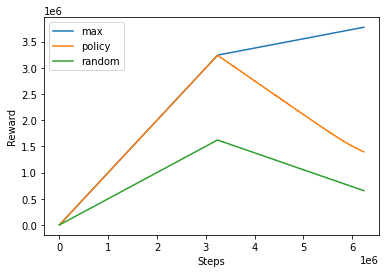

In [16]:
# plot the results
plt.plot(lin.max_total_rewards, label = 'max')
plt.plot(lin.total_rewards, label = 'policy')
plt.plot(lin.random_total_rewards, label = 'random')
plt.legend()
plt.xlabel('Steps')
_ = plt.ylabel('Reward')

* 235 first entries in the dataset feature only opened emails!
* Up to entry 3,247,692, over 99% of all emails have been opened!
* Opening ANY email seems like an excellent policy!

All opened up to step  235
Over 99% opened up to step 3247692


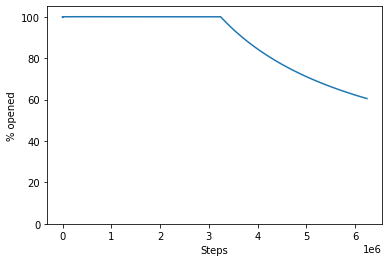

In [17]:
percent_open = []
total_open = 0
total_sent = 0
flag = True
flag2 = True
for i in range(len(rewards)):
    if rewards[i][0] > 0:
        total_open += 1
    total_sent += 1
    percent_open.append(total_open/total_sent*100)
    if total_open != total_sent and flag == True:
        flag = False
        print ("All opened up to step ", total_open-1)
    if percent_open[-1] < 99. and flag2 == True:
        flag2 = False
        print ("Over 99% opened up to step", total_open-1)

plt.plot(percent_open)
plt.ylim(0.,105.)
plt.xlabel('Steps')
_ = plt.ylabel('% opened')

# Testing the model on the last part of the snippet (entries >= 3247692)

In [18]:
# Set up the dataset
actions = 2
n_features = 3
contexts = []
rewards = []

for index, row in data.iterrows():
    if index >= 3247692:
        context = np.zeros((n_features,1))
        context[0][0] = row['retention_score']
        context[1][0] = row['recency_score']
        context[2][0] = row['frequency_score']
        contexts.append(context)
        if row['opened'] == 1:
            rewards.append(np.asarray([1., 0.]))
        else:
            rewards.append(np.asarray([-1., 0.]))

In [19]:
# create instance of LinUCB class with freshly initialized A and b parameters
lin = LinUCB(actions, contexts, rewards, True)
# run simulation in offline mode
lin.offLinUCB()

On this part of the data snippet, the performance of LinUCB isn't brilliant, but it is at least consistent, and consistently better than random.

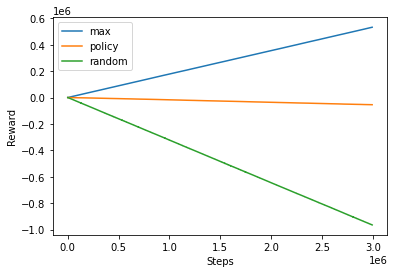

In [20]:
# plot the results
plt.plot(lin.max_total_rewards, label = 'max')
plt.plot(lin.total_rewards, label = 'policy')
plt.plot(lin.random_total_rewards, label = 'random')
plt.legend()
plt.xlabel('Steps')
_ = plt.ylabel('Reward')

That is because for this part of the data snippet, the percentage of opened emails is roughly constant throughout - a little under 20%.

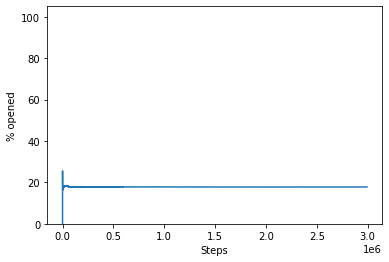

In [21]:
percent_open = []
total_open = 0
total_sent = 0
flag = True
flag2 = True
for i in range(len(rewards)):
    if rewards[i][0] > 0:
        total_open += 1
    total_sent += 1
    percent_open.append(total_open/total_sent*100)

plt.plot(percent_open)
plt.ylim(0.,105.)
plt.xlabel('Steps')
_ = plt.ylabel('% opened')

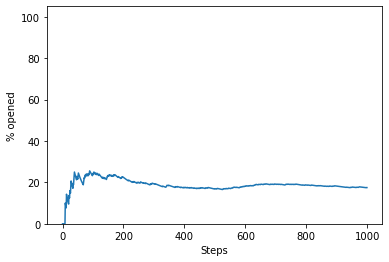

In [22]:
plt.plot(percent_open[:1000])
plt.ylim(0.,105.)
plt.xlabel('Steps')
_ = plt.ylabel('% opened')